## Import standard libraries

In [1]:
# Libraries used for hinting
from __future__ import annotations
from typing import Type, Union

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt, rc

# Import file system libraries
from pathlib import Path
import os

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'scalib'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)

Parent working directory: /Users/jjrr/Documents/SCA-Project/scalib


In [2]:
import numpy as np
import pandas as pd
import random

# Import custom libraries from local folder.
import sys
sys.path.append("..")

# Import utils library containing multiple functions/classes
from scalib import utils
from scalib import cfg

# Import class to create/manage CDMs
from scalib.cdm import ConjunctionDataMessage as CDM

# Import classes to handle Conjunction Events
from scalib.event import ConjunctionEvent as CE
from scalib.event import ConjunctionEventsDataset as CED

# Import NN classes to create NN models
import scalib.nn as nn
from scalib.nn import ConjunctionEventForecaster as CEF
from scalib.nn import CollisionRisk as CRE

# Import cells module to use different RNN cell architectures
import scalib.cells as cells

from scalib.kessler import LSTMPredictor

from scalib.eda import kelvins_challenge_events

import pandas as pd
import numpy as np 

utils.seed(1)

## Data preparation

In [3]:
#As an example, we first show the case in which the data comes from the Kelvins competition.
#For this, we built a specific converter that takes care of the conversion from Kelvins format
#to standard CDM format (the data can be downloaded at https://kelvins.esa.int/collision-avoidance-challenge/data/):
filepath = os.path.join(cwd,'data/esa-challenge/train_data.csv')

# Get ConjunctionEventsDataset object 
events = kelvins_challenge_events(filepath,
            drop_features = ['c_rcs_estimate', 't_rcs_estimate'], 
            num_events = 1000)

# Get features to train the model.
nn_features = events.common_features(only_numeric=True)
# print(utils.tabular_list(nn_features))

# Split data into a test set (5% of the total number of events)
len_test_set=int(0.05*len(events))

# Get Events to test model: used to compute the error the model would have in 
# run-mode.
events_test=events[-len_test_set:]
print('\nTest data:', events_test)

# Get events used for training and validation:
# - Training set: Used to train the model and backpropagate the loss.
# - Validation set: Used to compute the loss so that hyperparameters can be 
#   adjusted.
events_train_and_val=events[:-len_test_set]
print('Training and validation data:', events_train_and_val)

Kelvins Challenge dataset imported from external file (162634 entries):
/Users/jjrr/Documents/SCA-Project/scalib/data/esa-challenge/train_data.csv

| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1000/1000)| 00h:00m:05s |  195.04   | Dataset imported (1000 events).         

| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1000/1000)| 00h:00m:15s |   64.20   | Imported as DataFrame.                 

Test data: ConjunctionEventsDataset(Events:50 | Number of CDMs per event: 1 (min), 21 (max), 14.36 (mean))
Training and validation data: ConjunctionEventsDataset(Events:950 | Number of CDMs per event: 1 (min), 22 (max), 13.57 (mean))


## Model configuration

In [ ]:
# Define input and output size of the RNN model.
input_size = len(nn_features)
output_size = len(nn_features)

# Define number of output neurons per layer.
dropout = 0.2

In [ ]:
model_kessler = LSTMPredictor(lstm_size=256,  # Number of hidden units per LSTM layer
                    lstm_depth=2,  # Number of stacked LSTM layers
                    dropout = dropout,  # Dropout probability
                    features = nn_features)  # The list of feature names to use in the LSTM

In [4]:
import torch


layers = nn.ModuleDict({'lstm':torch.nn.LSTM(input_size = input_size, 
                                       hidden_size = 256, 
                                       num_layers = 2, 
                                       batch_first = True, 
                                       dropout = dropout if dropout else 0),
                        'dropout': nn.Dropout(p = dropout),
                        'relu': nn.ReLU(),
                        'linear': nn.Linear(256, output_size)})

# Create an LSTM predictor, specialized to the nn_features we extracted above
model_scalib = CEF(layers = layers, 
                   output_size = len(nn_features), 
                   features = nn_features)

layers_test = nn.ModuleDict({'lstm':nn.LSTM(input_size = input_size,
                                    hidden_size = 256,
                                    cell = cells.LSTM_Vanilla,
                                    num_layers = 2,
                                    dropout_probability = dropout if dropout else 0
                                    ),
                        'dropout': nn.Dropout(p = dropout),
                        'relu': nn.ReLU(),
                        'linear': nn.Linear(256, output_size)})


ModuleDict(
  (lstm): LSTM(66, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (linear): Linear(in_features=256, out_features=66, bias=True)
)


In [ ]:
layers_test = nn.ModuleDict({'lstm':nn.LSTM(input_size = input_size,
                                    hidden_size = 256,
                                    cell = cells.LSTM_Vanilla,
                                    num_layers = 2,
                                    dropout_probability = dropout if dropout else 0
                                    ),
                        'dropout': nn.Dropout(p = dropout),
                        'relu': nn.ReLU(),
                        'linear': nn.Linear(256, output_size)})

# Create an LSTM predictor, specialized to the nn_features we extracted above
model_scalib = CEF(layers = layers_test, 
                   output_size = len(nn_features), 
                   features = nn_features)



### Model training

In [6]:
# Start training
model_kessler.learn(events_train_and_val, 
            epochs=10, # Number of epochs (one epoch is one full pass through the training dataset)
            lr=1e-3, # Learning rate, can decrease it if training diverges
            batch_size=16, # Minibatch size, can be decreased if there are issues with memory use
            device='cpu', # Can be 'cuda' if there is a GPU available
            valid_proportion=0.15, # Proportion of the data to use as a validation set internally
            num_workers=4, # Number of multithreaded dataloader workers, 4 is good for performance, but if there are any issues or errors, please try num_workers=1 as this solves issues with PyTorch most of the time
            event_samples_for_stats=1000) # Number of events to use to compute NN normalization factors, have this number as big as possible (and at least a few thousands)

LSTM predictor with params: 875,074
Computing normalization statistics

| Progress                        |       Time       |    Iters/sec     | Comments
| |██████████| 100%       950/950 | 00d:00h:00m:00s  |     65536.00     | Conjunction Events dataset imported successfully.


In [5]:
# Start training
model_scalib.learn(events_train_and_val, 
            epochs=10, # Number of epochs (one epoch is one full pass through the training dataset)
            lr=1e-3, # Learning rate, can decrease it if training diverges
            batch_size=16, # Minibatch size, can be decreased if there are issues with memory use
            device='cpu', # Can be 'cuda' if there is a GPU available
            valid_proportion=0.15, # Proportion of the data to use as a validation set internally
            num_workers=4, # Number of multithreaded dataloader workers, 4 is good for performance, but if there are any issues or errors, please try num_workers=1 as this solves issues with PyTorch most of the time
            event_samples_for_stats=1000) # Number of events to use to compute NN normalization factors, have this number as big as possible (and at least a few thousands)

LSTM predictor with params: 875,074

| Progress                        |       Time       |    Iters/sec     | Comments
| |██████████| 100%       950/950 | 00d:00h:00m:00s  |     59074.70     | Conjunction Events dataset imported successfully.

| Progress                        |       Time       |    Iters/sec     | Comments


In [7]:
#NN loss plotted to a file:
model_kessler.plot_loss(log_scale=True)
model_scalib.plot_loss(log_scale=True)

NameError: name 'np' is not defined

In [9]:
#we take a single event, we remove the last CDM and try to predict it
event = events_test[3]
event_len = len(event)
print(event)

event_beginning = event[0:event_len-1]
print(event_beginning)
event_evolution = model_kessler.predict_event(event_beginning, num_samples=100, max_length=14)

ConjunctionEvent(CDMs: 11)
ConjunctionEvent(CDMs: 10)


AttributeError: module 'scalib.utils' has no attribute 'progress_bar_init'

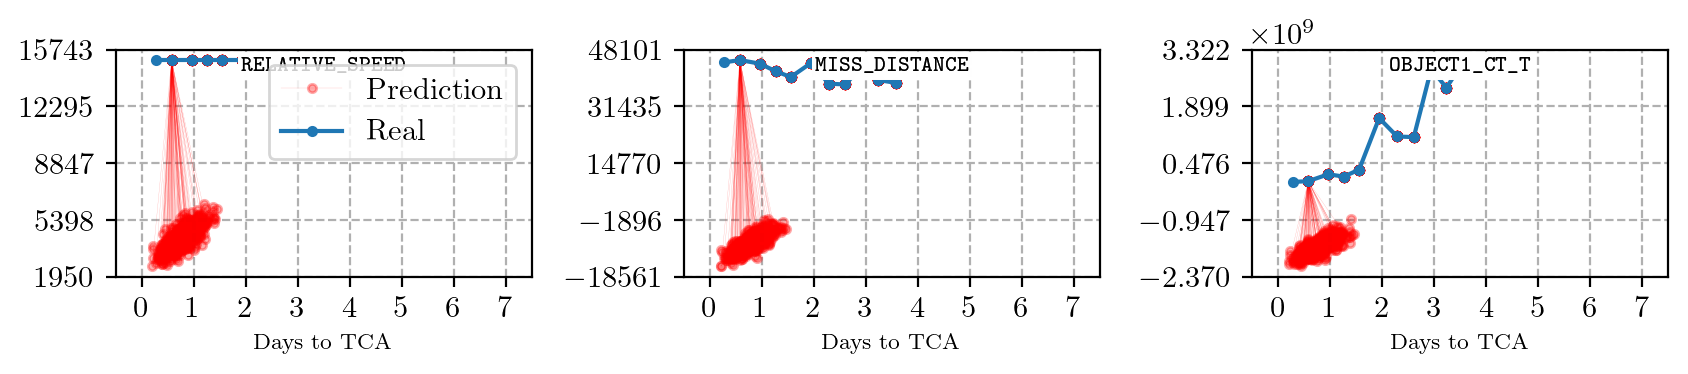

In [11]:
#We plot the prediction in red:
axs = event_evolution.plot_features(['RELATIVE_SPEED', 'MISS_DISTANCE', 'OBJECT1_CT_T'], return_axs=True, linewidth=0.1, color='red', alpha=0.33, label='Prediction')
#and the ground truth value in blue:
event.plot_features(['RELATIVE_SPEED', 'MISS_DISTANCE', 'OBJECT1_CT_T'], axs=axs, label='Real', legend=True)